## Customer Churn Predictor

In [2]:
import pandas as pd 
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder,LabelEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer


In [3]:
df=pd.read_csv('D:\ML\Customer_Churn_Predictor\Customer_Churn\data\WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df_copy=df.copy()

In [6]:
df_copy.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [7]:
categorical_cols = df_copy.select_dtypes(include=["object", "category"]).columns.tolist()
numerical_cols = df_copy.select_dtypes(include=["int64", "float64"]).columns.tolist()
print("Categorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols)

Categorical columns: ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges', 'Churn']
Numerical columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges']


In [8]:
for col in df.columns:
    if df[col].dtype == "object":
        print(f"{col}: {df[col].unique()}")


customerID: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
TotalCharges: ['29.85' '1889.5' '108.15' ... '346.45' '306.6' '6844.5']
Churn: ['No' 'Yes']


In [9]:

df_copy.drop(columns=["customerID"],axis=1,inplace=True)

In [10]:
#Feature classification
# Input features (drop the target column)
X = df_copy.drop("Churn", axis=1)
# Target/output column
y = df_copy["Churn"]

# 1. Custom cleaner
def clean_total_charges(X):
    X = X.copy()
    X["TotalCharges"] = X["TotalCharges"].astype(str).str.strip()
    X["TotalCharges"] = pd.to_numeric(X["TotalCharges"], errors="coerce")
    X["TotalCharges"] = X["TotalCharges"].fillna(X["TotalCharges"].median())
    return X

clean_total_charges_transformer = FunctionTransformer(clean_total_charges)

# 2. Column selections
categorical_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                    'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling',
                    'PaymentMethod']
ordinal_cols = ['Contract']
numerical_cols = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

# 3. Preprocessor
preprocessor = ColumnTransformer([
    ("ordinal", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1,
                               categories=[['Month-to-month', 'One year', 'Two year']]), ordinal_cols),
    ("onehot", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
     ("scaler", StandardScaler(), numerical_cols)
], remainder="passthrough")

# 4. Full Pipeline
pipeline = Pipeline([
    ("clean_total_charges", clean_total_charges_transformer),
    ("preprocessing", preprocessor),
    # ("model", LogisticRegression()) — You can add this step later
])

# 5. Encode y
le = LabelEncoder()
y = le.fit_transform(df_copy["Churn"])

# 6. Fit the pipeline
pipeline.fit(X, y)


,steps,"[('clean_total_charges', ...), ('preprocessing', ...)]"
,transform_input,None
,memory,None
,verbose,False
,func,<function cle...002022D0A72E0>
,inverse_func,None
,validate,False
,accept_sparse,False
,check_inverse,True
,feature_names_out,None
,kw_args,None


In [11]:
#let's split data for train and test
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=10)


In [12]:
#Hyperparameter tuning
lr=LogisticRegression(LogisticRegression(max_iter=1000))
c_values = [100, 10, 1.0, 0.1, 0.01]
params = [
    {
        'penalty': ['l1', 'l2'],
        'C': c_values,
        'solver': ['liblinear']
    },
    {
        'penalty': ['l2'],
        'C': c_values,
        'solver': ['lbfgs', 'newton-cg', 'sag']
    },
    {
        'penalty': ['l1', 'l2', 'elasticnet'],
        'C': c_values,
        'solver': ['saga'],
        'l1_ratio': [0.5]  # Only relevant for elasticnet
    }
]


## GridSearchCV
from sklearn.model_selection import GridSearchCV
grid_model=GridSearchCV(estimator=lr,param_grid=params,scoring='accuracy',cv=5,n_jobs=-1)


In [13]:
model_pipeline = Pipeline(steps=[
    ("clean_total_charges", clean_total_charges_transformer),
    ("preprocessing", preprocessor),
    ("Lregressor", grid_model)
])


In [14]:
model_pipeline.fit(X_train,y_train)

d:\ML\Customer_Churn_Predictor\venvp\lib\site-packages\sklearn\linear_model\_logistic.py:1213: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
d:\ML\Customer_Churn_Predictor\venvp\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,steps,"[('clean_total_charges', ...), ('preprocessing', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,func,<function cle...002022D0A72E0>
,inverse_func,None
,validate,False
,accept_sparse,False
,check_inverse,True
,feature_names_out,None
,kw_args,None


In [15]:
best_model = grid_model.best_estimator_

In [16]:
grid_model.best_score_

np.float64(0.8061390871821335)

In [17]:
final_pipeline = Pipeline(steps=[
    ("clean_total_charges", clean_total_charges_transformer),
    ("preprocessing", preprocessor),
    ("Lregressor", best_model)
])


In [18]:
final_pipeline.fit(X_train,y_train)

d:\ML\Customer_Churn_Predictor\venvp\lib\site-packages\sklearn\linear_model\_logistic.py:1213: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
d:\ML\Customer_Churn_Predictor\venvp\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,steps,"[('clean_total_charges', ...), ('preprocessing', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,func,<function cle...002022D0A72E0>
,inverse_func,None
,validate,False
,accept_sparse,False
,check_inverse,True
,feature_names_out,None
,kw_args,None


In [19]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
y_pred=final_pipeline.predict(X_test)

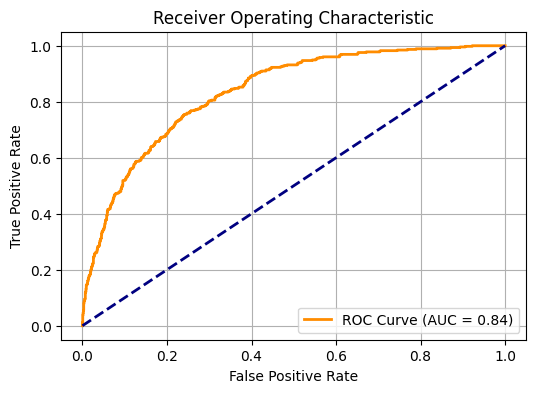

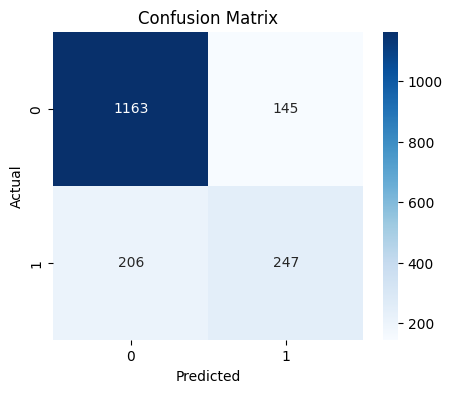

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1308
           1       0.63      0.55      0.58       453

    accuracy                           0.80      1761
   macro avg       0.74      0.72      0.73      1761
weighted avg       0.79      0.80      0.80      1761



In [23]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# ROC Curve
y_proba = final_pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns





Analysis


In [21]:
score=accuracy_score(y_pred,y_test)
print(score)
print(classification_report(y_pred,y_test))
print(confusion_matrix(y_pred,y_test))

0.8006814310051107
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      1369
           1       0.55      0.63      0.58       392

    accuracy                           0.80      1761
   macro avg       0.72      0.74      0.73      1761
weighted avg       0.81      0.80      0.81      1761

[[1163  206]
 [ 145  247]]


Pikling

In [22]:
import pickle
pickle.dump(final_pipeline, open("model.pkl",'wb'))

with open("X_test.pkl", "wb") as f:
    pickle.dump(X_test, f)

with open("y_test.pkl", "wb") as f:
    pickle.dump(y_test, f)
